In [7]:
import pandas as pd
import os
import requests
import shelve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
import statsmodels 
from scipy.stats import mannwhitneyu
from statsmodels.sandbox.stats.runs import runstest_1samp

In [8]:
user="Lilian"
years_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
#user in personal pc1 <- "asus"

Doing the statistical analysis. Be careful with the units scale

In [ ]:
class NDCATC_ind:  #Creating a new class to analyze correlations
    
    @staticmethod 
    def correlation_look(years_list, base_path=None, min_records=25):
        
        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("CORRELATION ANALYSIS: Units Reimbursed vs Number of Prescriptions")
        print("THREE-PANEL ANALYSIS")
        print("="*70)
        
        results = {
            'panel1_state_atc2': [],
            'panel2_national_atc2': [], 
            'panel3_atc2_quarter': []
        }
        
        # Load all data first
        all_data = {}
        for year in years_list:
            print(f"Loading {year} data...", end=" ")
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                records['ATC2 Class'] = records['ATC4 Class'].str[:3]
                all_data[year] = records
                print(f"✓ ({len(records):,} records)")
            except Exception as e:
                print(f"✗ Error: {e}")
        
        # ==================== PANEL 1: STATE x ATC2 ANALYSIS ====================
        print(f"\n{'='*70}")
        print("PANEL 1: STATE x ATC2 CORRELATION ANALYSIS")
        print(f"{'='*70}")
        
        for year in years_list:
            if year not in all_data:
                continue
                
            records = all_data[year]
            
            for state in records['State'].unique():
                state_data = records[records['State'] == state]
                
                for atc2 in state_data['ATC2 Class'].unique():
                    subset = state_data[state_data['ATC2 Class'] == atc2]
                    
                    if len(subset) >= min_records:
                        try:
                            # Get ATC2 name
                            atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                            
                            # Calculate correlations
                            pearson_r, pearson_p = pearsonr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                            spearman_r, spearman_p = spearmanr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                            
                            results['panel1_state_atc2'].append({
                                'Year': year,
                                'State': state,
                                'ATC2_Class': atc2,
                                'ATC2_Name': atc2_name,
                                'N_Records': len(subset),
                                'Pearson_r': pearson_r,
                                'Pearson_p': pearson_p,
                                'Spearman_r': spearman_r,
                                'Spearman_p': spearman_p,
                                'Mean_Units': subset['Units Reimbursed'].mean(),
                                'Mean_Prescriptions': subset['Number of Prescriptions'].mean()
                            })
                            
                        except Exception as e:
                            print(f"Error processing {state}-{atc2}: {e}")
        
        # Display Panel 1 results
        panel1_df = pd.DataFrame(results['panel1_state_atc2'])
        if not panel1_df.empty:
            print(f"\nPanel 1 Results: {len(panel1_df)} state x ATC2 combinations analyzed")
            
            # Summary statistics
            print(f"Average Pearson correlation: {panel1_df['Pearson_r'].mean():.4f}")
            print(f"Range: {panel1_df['Pearson_r'].min():.4f} to {panel1_df['Pearson_r'].max():.4f}")
            print(f"Significant correlations (p<0.05): {(panel1_df['Pearson_p'] < 0.05).sum()}/{len(panel1_df)} ({100*(panel1_df['Pearson_p'] < 0.05).sum()/len(panel1_df):.1f}%)")
            
            # Top correlations
            print(f"\nTop 10 Highest Pearson Correlations (State x ATC2):")
            top_corr = panel1_df.nlargest(10, 'Pearson_r')[['State', 'ATC2_Class', 'ATC2_Name', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            top_corr['Pearson_p'] = top_corr['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_corr.to_string(index=False))
            
            # Lowest correlations
            print(f"\nTop 10 Lowest Pearson Correlations (State x ATC2):")
            low_corr = panel1_df.nsmallest(10, 'Pearson_r')[['State', 'ATC2_Class', 'ATC2_Name', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            low_corr['Pearson_p'] = low_corr['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(low_corr.to_string(index=False))
        
        # ==================== PANEL 2: NATIONAL x ATC2 ANALYSIS ====================
        print(f"\n{'='*70}")
        print("PANEL 2: NATIONAL x ATC2 CORRELATION ANALYSIS")
        print(f"{'='*70}")
        
        for year in years_list:
            if year not in all_data:
                continue
                
            records = all_data[year]
            
            for atc2 in records['ATC2 Class'].unique():
                subset = records[records['ATC2 Class'] == atc2]
                
                if len(subset) >= min_records:
                    try:
                        atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                        
                        # Calculate correlations
                        pearson_r, pearson_p = pearsonr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                        spearman_r, spearman_p = spearmanr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                        
                        results['panel2_national_atc2'].append({
                            'Year': year,
                            'ATC2_Class': atc2,
                            'ATC2_Name': atc2_name,
                            'N_Records': len(subset),
                            'N_States': subset['State'].nunique(),
                            'Pearson_r': pearson_r,
                            'Pearson_p': pearson_p,
                            'Spearman_r': spearman_r,
                            'Spearman_p': spearman_p,
                            'Mean_Units': subset['Units Reimbursed'].mean(),
                            'Mean_Prescriptions': subset['Number of Prescriptions'].mean()
                        })
                        
                    except Exception as e:
                        print(f"Error processing National-{atc2}: {e}")
        
        # Display Panel 2 results
        panel2_df = pd.DataFrame(results['panel2_national_atc2'])
        if not panel2_df.empty:
            print(f"\nPanel 2 Results: {len(panel2_df)} national x ATC2 combinations analyzed")
            
            print(f"Average Pearson correlation: {panel2_df['Pearson_r'].mean():.4f}")
            print(f"Range: {panel2_df['Pearson_r'].min():.4f} to {panel2_df['Pearson_r'].max():.4f}")
            print(f"Significant correlations (p<0.05): {(panel2_df['Pearson_p'] < 0.05).sum()}/{len(panel2_df)} ({100*(panel2_df['Pearson_p'] < 0.05).sum()/len(panel2_df):.1f}%)")
            
            print(f"\nTop 10 Highest Pearson Correlations (National x ATC2):")
            top_corr_nat = panel2_df.nlargest(10, 'Pearson_r')[['Year', 'ATC2_Class', 'ATC2_Name', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            top_corr_nat['Pearson_p'] = top_corr_nat['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_corr_nat.to_string(index=False))
            
            print(f"\nTop 10 Lowest Pearson Correlations (National x ATC2):")
            low_corr_nat = panel2_df.nsmallest(10, 'Pearson_r')[['Year', 'ATC2_Class', 'ATC2_Name', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            low_corr_nat['Pearson_p'] = low_corr_nat['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(low_corr_nat.to_string(index=False))
        
        # ==================== PANEL 3: ATC2 x QUARTER ANALYSIS ====================
        print(f"\n{'='*70}")
        print("PANEL 3: ATC2 x QUARTER CORRELATION ANALYSIS")
        print(f"{'='*70}")
        
        # Combine all years first
        all_combined = []
        for year, records in all_data.items():
            records_copy = records.copy()
            records_copy['Year'] = year
            all_combined.append(records_copy)
        
        if all_combined:
            combined_df = pd.concat(all_combined, ignore_index=True)
            
            for atc2 in combined_df['ATC2 Class'].unique():
                atc2_data = combined_df[combined_df['ATC2 Class'] == atc2]
                
                for quarter in sorted(atc2_data['Quarter'].unique()):
                    subset = atc2_data[atc2_data['Quarter'] == quarter]
                    
                    if len(subset) >= min_records:
                        try:
                            atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                            
                            # Calculate correlations
                            pearson_r, pearson_p = pearsonr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                            spearman_r, spearman_p = spearmanr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                            
                            results['panel3_atc2_quarter'].append({
                                'ATC2_Class': atc2,
                                'ATC2_Name': atc2_name,
                                'Quarter': quarter,
                                'N_Records': len(subset),
                                'N_Years': subset['Year'].nunique(),
                                'N_States': subset['State'].nunique(),
                                'Pearson_r': pearson_r,
                                'Pearson_p': pearson_p,
                                'Spearman_r': spearman_r,
                                'Spearman_p': spearman_p,
                                'Mean_Units': subset['Units Reimbursed'].mean(),
                                'Mean_Prescriptions': subset['Number of Prescriptions'].mean()
                            })
                            
                        except Exception as e:
                            print(f"Error processing {atc2}-Q{quarter}: {e}")
        
        # Display Panel 3 results
        panel3_df = pd.DataFrame(results['panel3_atc2_quarter'])
        if not panel3_df.empty:
            print(f"\nPanel 3 Results: {len(panel3_df)} ATC2 x quarter combinations analyzed")
            
            print(f"Average Pearson correlation: {panel3_df['Pearson_r'].mean():.4f}")
            print(f"Range: {panel3_df['Pearson_r'].min():.4f} to {panel3_df['Pearson_r'].max():.4f}")
            print(f"Significant correlations (p<0.05): {(panel3_df['Pearson_p'] < 0.05).sum()}/{len(panel3_df)} ({100*(panel3_df['Pearson_p'] < 0.05).sum()/len(panel3_df):.1f}%)")
            
            # Summary by Quarter
            quarter_summary = panel3_df.groupby('Quarter').agg({
                'Pearson_r': ['mean', 'std', 'min', 'max'], 'N_Records': 'sum'
            }).round(4)
            quarter_summary.columns = ['Avg_Pearson', 'Std_Pearson', 'Min_Pearson', 'Max_Pearson', 'Total_Records']
            
            print(f"\nCorrelation Summary by Quarter:")
            print(f"{'Quarter':<8} {'Avg':<8} {'Std':<8} {'Min':<8} {'Max':<8} {'Records':<10}")
            print("-" * 60)
            for quarter, row in quarter_summary.iterrows():
                print(f"Q{quarter:<7} {row['Avg_Pearson']:<8.4f} {row['Std_Pearson']:<8.4f} {row['Min_Pearson']:<8.4f} {row['Max_Pearson']:<8.4f} {row['Total_Records']:<10.0f}")
            
            print(f"\nTop 10 Highest Pearson Correlations (ATC2 x Quarter):")
            top_corr_quarter = panel3_df.nlargest(10, 'Pearson_r')[['ATC2_Class', 'ATC2_Name', 'Quarter', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            top_corr_quarter['Pearson_p'] = top_corr_quarter['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_corr_quarter.to_string(index=False))
            
            print(f"\nTop 10 Lowest Pearson Correlations (ATC2 x Quarter):")
            low_corr_quarter = panel3_df.nsmallest(10, 'Pearson_r')[['ATC2_Class', 'ATC2_Name', 'Quarter', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            low_corr_quarter['Pearson_p'] = low_corr_quarter['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(low_corr_quarter.to_string(index=False))
        
        # ==================== COMPARATIVE SUMMARY ACROSS PANELS ====================
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY ACROSS ALL THREE PANELS")
        print(f"{'='*80}")
        
        summary_data = []
        
        if not panel1_df.empty:
            panel1_avg = panel1_df['Pearson_r'].mean()
            panel1_std = panel1_df['Pearson_r'].std()
            panel1_sig = (panel1_df['Pearson_p'] < 0.05).sum()
            panel1_total = len(panel1_df)
            summary_data.append(['State x ATC2', panel1_total, panel1_avg, panel1_std, panel1_sig])
        
        if not panel2_df.empty:
            panel2_avg = panel2_df['Pearson_r'].mean()
            panel2_std = panel2_df['Pearson_r'].std()
            panel2_sig = (panel2_df['Pearson_p'] < 0.05).sum()
            panel2_total = len(panel2_df)
            summary_data.append(['National x ATC2', panel2_total, panel2_avg, panel2_std, panel2_sig])
        
        if not panel3_df.empty:
            panel3_avg = panel3_df['Pearson_r'].mean()
            panel3_std = panel3_df['Pearson_r'].std()
            panel3_sig = (panel3_df['Pearson_p'] < 0.05).sum()
            panel3_total = len(panel3_df)
            summary_data.append(['ATC2 x Quarter', panel3_total, panel3_avg, panel3_std, panel3_sig])
        
        if summary_data:
            summary_df = pd.DataFrame(summary_data, columns=['Panel', 'Total_Tests', 'Avg_Pearson', 'Std_Pearson', 'Sig_Correlations'])
            summary_df['Sig_Percentage'] = (summary_df['Sig_Correlations'] / summary_df['Total_Tests'] * 100).round(1)
            summary_df['Avg_Pearson'] = summary_df['Avg_Pearson'].round(4)
            summary_df['Std_Pearson'] = summary_df['Std_Pearson'].round(4)
            
            print(summary_df.to_string(index=False))
            
            # Additional insights
            print(f"\nKey Insights:")
            if len(summary_data) > 1:
                highest_avg_panel = summary_df.loc[summary_df['Avg_Pearson'].idxmax(), 'Panel']
                lowest_avg_panel = summary_df.loc[summary_df['Avg_Pearson'].idxmin(), 'Panel']
                print(f"  - Highest average correlation: {highest_avg_panel}")
                print(f"  - Lowest average correlation: {lowest_avg_panel}")
                
                highest_sig_panel = summary_df.loc[summary_df['Sig_Percentage'].idxmax(), 'Panel']
                print(f"  - Most significant correlations: {highest_sig_panel}")
        
        print(f"\nNote: Correlations measure linear (Pearson) and monotonic (Spearman) relationships.")
        print(f"Significant p-values (< 0.05) indicate correlations likely not due to chance.")
        
        # Convert results to DataFrames for return
        results_dfs = {
            'panel1_state_atc2': panel1_df,
            'panel2_national_atc2': panel2_df,
            'panel3_atc2_quarter': panel3_df
        }
        
        return results_dfs

    @staticmethod #This is for Indiana data
    def plot_units_vs_prescriptions_by_atc(years_list, base_path=None, min_records=25, include_negative=True):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("Creating plots for Indiana ATC classes...")
        
        # Combine all years of data
        all_data = []
        for year in years_list:
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                records = df_merged[(df_merged['ATC4 Class'].notna()) & (df_merged['State'] == 'IN')].copy()
                records['Year'] = year
                all_data.append(records)
            except Exception as e:
                print(f"Error loading {year}: {e}")
        
        if not all_data:
            print("No data loaded!")
            return
        
        combined_df = pd.concat(all_data, ignore_index=True)
        
        # Get ATC classes with sufficient data and calculate correlations
        atc_counts = combined_df['ATC2 Class'].value_counts()
        sufficient_data_classes = atc_counts[atc_counts >= min_records].index
        
        # Calculate correlations for all classes with sufficient data
        class_correlations = {}
        for atc_class in sufficient_data_classes:
            subset = combined_df[combined_df['ATC2 Class'] == atc_class]
            if len(subset) > 1:
                corr = subset['Number of Prescriptions'].corr(subset['Units Reimbursed'])
                class_correlations[atc_class] = corr
        
        # Select classes to plot
        if include_negative:
            # Get top positive correlations and all negative correlations
            positive_corrs = {k: v for k, v in class_correlations.items() if v >= 0}
            negative_corrs = {k: v for k, v in class_correlations.items() if v < 0}
            
            # Sort positive by correlation (descending) and negative by correlation (ascending, most negative first)
            positive_sorted = sorted(positive_corrs.items(), key=lambda x: x[1], reverse=True)
            negative_sorted = sorted(negative_corrs.items(), key=lambda x: x[1])
            
            # Take top 8 positive and all negative (up to 4 more)
            selected_positive = [x[0] for x in positive_sorted[:8]]
            selected_negative = [x[0] for x in negative_sorted[:4]]
            
            valid_atc_classes = selected_positive + selected_negative
            
            print(f"\nSelected classes: {len(selected_positive)} positive correlations + {len(selected_negative)} negative correlations")
            if selected_negative:
                print(f"Negative correlation classes: {selected_negative}")
        else:
            # Original behavior - top classes by count
            valid_atc_classes = sufficient_data_classes[:12]
        
        # Determine grid size based on number of classes
        n_classes = len(valid_atc_classes)
        if n_classes <= 6:
            rows, cols = 2, 3
        elif n_classes <= 9:
            rows, cols = 3, 3
        elif n_classes <= 12:
            rows, cols = 3, 4
        else:
            rows, cols = 4, 4
            valid_atc_classes = valid_atc_classes[:16]  # Limit to 16 for display
        
        # Set up the plot grid
        fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
        if rows == 1 or cols == 1:
            axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        else:
            axes = axes.flatten()
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(valid_atc_classes)))
        
        for i, atc_class in enumerate(valid_atc_classes):
            subset = combined_df[combined_df['ATC2 Class'] == atc_class]
            atc_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns and not subset['ATC2_Name'].isna().all() else atc_class
            
            # Create scatter plot
            axes[i].scatter(subset['Number of Prescriptions'], 
                           subset['Units Reimbursed'], 
                           alpha=0.6, color=colors[i], s=20)
            
            # Add trend line
            if len(subset) > 1:
                z = np.polyfit(subset['Number of Prescriptions'], subset['Units Reimbursed'], 1)
                p = np.poly1d(z)
                axes[i].plot(subset['Number of Prescriptions'], p(subset['Number of Prescriptions']), 
                            "r--", alpha=0.8, linewidth=1)
            
            # Format axes
            axes[i].set_xlabel('Number of Prescriptions')
            axes[i].set_ylabel('Units Reimbursed')
            axes[i].set_title(f'{atc_class}\n{atc_name[:30]}', fontsize=10)
            axes[i].grid(True, alpha=0.3)
            
            # Add correlation coefficient with color coding
            if len(subset) > 1:
                corr = subset['Number of Prescriptions'].corr(subset['Units Reimbursed'])
                color = 'red' if corr < 0 else 'blue'
                axes[i].text(0.05, 0.95, f'r = {corr:.3f}', 
                            transform=axes[i].transAxes, 
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor=color),
                            fontsize=9, color=color)
        
        # Hide unused subplots
        for j in range(len(valid_atc_classes), len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        title_suffix = " (Including Negative Correlations)" if include_negative else ""
        plt.suptitle(f'Indiana: Units Reimbursed vs Number of Prescriptions by ATC2 Class{title_suffix}\n(All Years Combined)', 
                     fontsize=16, y=1.02)
        plt.show()
        
        # Summary table
        print(f"\n{'='*80}")
        print("PLOT SUMMARY - INDIANA ATC CLASSES")
        print(f"{'='*80}")
        print(f"{'ATC2':<5} {'Name':<30} {'Records':<8} {'Correlation':<12} {'Type':<8}")
        print("-" * 90)
        
        for atc_class in valid_atc_classes:
            subset = combined_df[combined_df['ATC2 Class'] == atc_class]
            atc_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns and not subset['ATC2_Name'].isna().all() else atc_class
            corr = subset['Number of Prescriptions'].corr(subset['Units Reimbursed'])
            corr_type = "Negative" if corr < 0 else "Positive"
            
            print(f"{atc_class:<5} {atc_name[:28]:<30} {len(subset):<8} {corr:<12.4f} {corr_type:<8}")
        
        return combined_df[combined_df['ATC2 Class'].isin(valid_atc_classes)]
    
    @staticmethod
    def runs_test_analysis(years_list, base_path=None, min_records=25, generate_heatmaps=False, export_results=False):
        
        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("RUNS TEST ANALYSIS: Testing for Randomness in Units Reimbursed and Number of Prescriptions")
        print("="*80)
        
        all_results = {
            'state_atc2': [],
            'national_atc2': [], 
            'atc2_quarter': []
        }
        
        # Load all data first
        all_data = {}
        for year in years_list:
            print(f"Loading {year} data...", end=" ")
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                records['ATC2 Class'] = records['ATC4 Class'].str[:3]
                all_data[year] = records
                print(f"✓ ({len(records):,} records)")
            except Exception as e:
                print(f"✗ Error: {e}")
        
        print(f"\n{'='*80}")
        print("PANEL 1: STATE x ATC2 CLASSES RUNS TEST")
        print(f"{'='*80}")
        
        # Panel 1: State x ATC2 classes
        for year in years_list:
            if year not in all_data:
                continue
                
            records = all_data[year]
            
            for state in records['State'].unique():
                state_data = records[records['State'] == state]
                
                for atc2 in state_data['ATC2 Class'].unique():
                    subset = state_data[state_data['ATC2 Class'] == atc2]
                    
                    if len(subset) >= min_records:
                        try:
                            # Get ATC2 name
                            atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                            
                            # Sort by Year and Quarter to create sequence
                            subset_sorted = subset.sort_values(['Year', 'Quarter'])
                            
                            # Test Units Reimbursed
                            units_values = subset_sorted['Units Reimbursed'].values
                            units_median = np.median(units_values)
                            units_binary = (units_values > units_median).astype(int)
                            
                            if len(np.unique(units_binary)) > 1:  # Need both 0s and 1s
                                runs_stat_units, p_val_units = runstest_1samp(units_binary)
                            else:
                                runs_stat_units, p_val_units = np.nan, np.nan
                            
                            # Test Number of Prescriptions  
                            presc_values = subset_sorted['Number of Prescriptions'].values
                            presc_median = np.median(presc_values)
                            presc_binary = (presc_values > presc_median).astype(int)
                            
                            if len(np.unique(presc_binary)) > 1:
                                runs_stat_presc, p_val_presc = runstest_1samp(presc_binary)
                            else:
                                runs_stat_presc, p_val_presc = np.nan, np.nan
                            
                            all_results['state_atc2'].append({
                                'Year': year,
                                'State': state,
                                'ATC2_Class': atc2,
                                'ATC2_Name': atc2_name,
                                'N_Records': len(subset),
                                'Units_Runs_Stat': runs_stat_units,
                                'Units_P_Value': p_val_units,
                                'Presc_Runs_Stat': runs_stat_presc,
                                'Presc_P_Value': p_val_presc
                            })
                            
                        except Exception as e:
                            print(f"Error processing {state}-{atc2}: {e}")
        
        # Convert to DataFrame and display results
        state_atc2_df = pd.DataFrame(all_results['state_atc2'])
        if not state_atc2_df.empty:
            print(f"\nState x ATC2 Results: {len(state_atc2_df)} combinations analyzed")
            
            # Summary statistics
            units_significant = (state_atc2_df['Units_P_Value'] < 0.05).sum()
            presc_significant = (state_atc2_df['Presc_P_Value'] < 0.05).sum() 
            total_valid = state_atc2_df['Units_P_Value'].notna().sum()
            
            print(f"Units Reimbursed - Significant non-randomness: {units_significant}/{total_valid} ({100*units_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            print(f"Number of Prescriptions - Significant non-randomness: {presc_significant}/{total_valid} ({100*presc_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            
            # Top significant results
            print(f"\nTop 10 Most Significant Units Reimbursed Results (State x ATC2):")
            top_units = state_atc2_df.nsmallest(10, 'Units_P_Value')[['State', 'ATC2_Class', 'ATC2_Name', 'Units_Runs_Stat', 'Units_P_Value', 'N_Records']].copy()
            top_units['Units_P_Value'] = top_units['Units_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_units.to_string(index=False))
            
            print(f"\nTop 10 Most Significant Number of Prescriptions Results (State x ATC2):")
            top_presc = state_atc2_df.nsmallest(10, 'Presc_P_Value')[['State', 'ATC2_Class', 'ATC2_Name', 'Presc_Runs_Stat', 'Presc_P_Value', 'N_Records']].copy()
            top_presc['Presc_P_Value'] = top_presc['Presc_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_presc.to_string(index=False))
        
        print(f"\n{'='*80}")
        print("PANEL 2: NATIONAL x ATC2 CLASSES RUNS TEST") 
        print(f"{'='*80}")
        
        # Panel 2: National x ATC2 classes (aggregate all states per year)
        for year in years_list:
            if year not in all_data:
                continue
                
            records = all_data[year]
            
            for atc2 in records['ATC2 Class'].unique():
                subset = records[records['ATC2 Class'] == atc2]
                
                if len(subset) >= min_records:
                    try:
                        atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                        
                        # Sort by Year and Quarter to create a systematic sequence
                        subset_sorted = subset.sort_values(['Year', 'Quarter'])
                        
                        # Test Units Reimbursed
                        units_values = subset_sorted['Units Reimbursed'].values
                        units_median = np.median(units_values)
                        units_binary = (units_values > units_median).astype(int)
                        
                        if len(np.unique(units_binary)) > 1:
                            runs_stat_units, p_val_units = runstest_1samp(units_binary)
                        else:
                            runs_stat_units, p_val_units = np.nan, np.nan
                        
                        # Test Number of Prescriptions
                        presc_values = subset_sorted['Number of Prescriptions'].values
                        presc_median = np.median(presc_values)
                        presc_binary = (presc_values > presc_median).astype(int)
                        
                        if len(np.unique(presc_binary)) > 1:
                            runs_stat_presc, p_val_presc = runstest_1samp(presc_binary)
                        else:
                            runs_stat_presc, p_val_presc = np.nan, np.nan
                        
                        all_results['national_atc2'].append({
                            'Year': year,
                            'ATC2_Class': atc2,
                            'ATC2_Name': atc2_name,
                            'N_Records': len(subset),
                            'N_States': subset['State'].nunique(),
                            'Units_Runs_Stat': runs_stat_units,
                            'Units_P_Value': p_val_units,
                            'Presc_Runs_Stat': runs_stat_presc,
                            'Presc_P_Value': p_val_presc
                        })
                        
                    except Exception as e:
                        print(f"Error processing National-{atc2}: {e}")
        
        # Display National x ATC2 results
        national_atc2_df = pd.DataFrame(all_results['national_atc2'])
        if not national_atc2_df.empty:
            print(f"\nPanel 2 Results: {len(national_atc2_df)} national x ATC2 combinations analyzed")
            
            units_significant = (national_atc2_df['Units_P_Value'] < 0.05).sum()
            presc_significant = (national_atc2_df['Presc_P_Value'] < 0.05).sum()
            total_valid = national_atc2_df['Units_P_Value'].notna().sum()
            
            print(f"Units Reimbursed - Significant non-randomness: {units_significant}/{total_valid} ({100*units_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            print(f"Number of Prescriptions - Significant non-randomness: {presc_significant}/{total_valid} ({100*presc_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            
            print(f"\nTop 10 Most Significant Units Reimbursed Results (National x ATC2):")
            top_units_nat = national_atc2_df.nsmallest(10, 'Units_P_Value')[['Year', 'ATC2_Class', 'ATC2_Name', 'Units_Runs_Stat', 'Units_P_Value', 'N_Records']].copy()
            top_units_nat['Units_P_Value'] = top_units_nat['Units_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_units_nat.to_string(index=False))
            
            print(f"\nTop 10 Most Significant Number of Prescriptions Results (National x ATC2):")
            top_presc_nat = national_atc2_df.nsmallest(10, 'Presc_P_Value')[['Year', 'ATC2_Class', 'ATC2_Name', 'Presc_Runs_Stat', 'Presc_P_Value', 'N_Records']].copy()
            top_presc_nat['Presc_P_Value'] = top_presc_nat['Presc_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_presc_nat.to_string(index=False))
        
        print(f"\n{'='*80}")
        print("PANEL 3: ATC2 CLASSES x QUARTER RUNS TEST")
        print(f"{'='*80}")
        
        # Panel 3: ATC2 classes x Quarter (aggregate all years)
        # Combine all years first
        all_combined = []
        for year, records in all_data.items():
            records_copy = records.copy()
            records_copy['Year'] = year
            all_combined.append(records_copy)
        
        if all_combined:
            combined_df = pd.concat(all_combined, ignore_index=True)
            
            for atc2 in combined_df['ATC2 Class'].unique():
                atc2_data = combined_df[combined_df['ATC2 Class'] == atc2]
                
                for quarter in sorted(atc2_data['Quarter'].unique()):
                    subset = atc2_data[atc2_data['Quarter'] == quarter]
                    
                    if len(subset) >= min_records:
                        try:
                            atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                            
                            # Sort by Year and Quarter
                            subset_sorted = subset.sort_values(['Year', 'Quarter'])
                            
                            # Test Units Reimbursed
                            units_values = subset_sorted['Units Reimbursed'].values
                            units_median = np.median(units_values)
                            units_binary = (units_values > units_median).astype(int)
                            
                            if len(np.unique(units_binary)) > 1:
                                runs_stat_units, p_val_units = runstest_1samp(units_binary)
                            else:
                                runs_stat_units, p_val_units = np.nan, np.nan
                            
                            # Test Number of Prescriptions
                            presc_values = subset_sorted['Number of Prescriptions'].values
                            presc_median = np.median(presc_values)
                            presc_binary = (presc_values > presc_median).astype(int)
                            
                            if len(np.unique(presc_binary)) > 1:
                                runs_stat_presc, p_val_presc = runstest_1samp(presc_binary)
                            else:
                                runs_stat_presc, p_val_presc = np.nan, np.nan
                            
                            all_results['atc2_quarter'].append({
                                'ATC2_Class': atc2,
                                'ATC2_Name': atc2_name,
                                'Quarter': quarter,
                                'N_Records': len(subset),
                                'N_Years': subset['Year'].nunique(),
                                'N_States': subset['State'].nunique(),
                                'Units_Runs_Stat': runs_stat_units,
                                'Units_P_Value': p_val_units,
                                'Presc_Runs_Stat': runs_stat_presc,
                                'Presc_P_Value': p_val_presc
                            })
                            
                        except Exception as e:
                            print(f"Error processing {atc2}-Q{quarter}: {e}")
        
        # Display ATC2 x Quarter results
        atc2_quarter_df = pd.DataFrame(all_results['atc2_quarter'])
        if not atc2_quarter_df.empty:
            print(f"\nATC2 x Quarter Results: {len(atc2_quarter_df)} combinations analyzed")
            
            units_significant = (atc2_quarter_df['Units_P_Value'] < 0.05).sum()
            presc_significant = (atc2_quarter_df['Presc_P_Value'] < 0.05).sum()
            total_valid = atc2_quarter_df['Units_P_Value'].notna().sum()
            
            print(f"Units Reimbursed - Significant non-randomness: {units_significant}/{total_valid} ({100*units_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            print(f"Number of Prescriptions - Significant non-randomness: {presc_significant}/{total_valid} ({100*presc_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            
            print(f"\nTop 10 Most Significant Units Reimbursed Results (ATC2 x Quarter):")
            top_units_quarter = atc2_quarter_df.nsmallest(10, 'Units_P_Value')[['ATC2_Class', 'ATC2_Name', 'Quarter', 'Units_Runs_Stat', 'Units_P_Value', 'N_Records']].copy()
            top_units_quarter['Units_P_Value'] = top_units_quarter['Units_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_units_quarter.to_string(index=False))
            
            print(f"\nTop 10 Most Significant Number of Prescriptions Results (ATC2 x Quarter):")
            top_presc_quarter = atc2_quarter_df.nsmallest(10, 'Presc_P_Value')[['ATC2_Class', 'ATC2_Name', 'Quarter', 'Presc_Runs_Stat', 'Presc_P_Value', 'N_Records']].copy()
            top_presc_quarter['Presc_P_Value'] = top_presc_quarter['Presc_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_presc_quarter.to_string(index=False))
        
        # SUMMARY SECTION
        print(f"\n{'='*80}")
        print("RUNS TEST SUMMARY")
        print(f"{'='*80}")
        
        summary_data = []
        
        if not state_atc2_df.empty:
            state_units_sig = (state_atc2_df['Units_P_Value'] < 0.05).sum()
            state_presc_sig = (state_atc2_df['Presc_P_Value'] < 0.05).sum()
            state_total = state_atc2_df['Units_P_Value'].notna().sum()
            summary_data.append(['State x ATC2', state_total, state_units_sig, state_presc_sig])
        
        if not national_atc2_df.empty:
            nat_units_sig = (national_atc2_df['Units_P_Value'] < 0.05).sum()
            nat_presc_sig = (national_atc2_df['Presc_P_Value'] < 0.05).sum()
            nat_total = national_atc2_df['Units_P_Value'].notna().sum()
            summary_data.append(['National x ATC2', nat_total, nat_units_sig, nat_presc_sig])
        
        if not atc2_quarter_df.empty:
            quarter_units_sig = (atc2_quarter_df['Units_P_Value'] < 0.05).sum()
            quarter_presc_sig = (atc2_quarter_df['Presc_P_Value'] < 0.05).sum()
            quarter_total = atc2_quarter_df['Units_P_Value'].notna().sum()
            summary_data.append(['ATC2 x Quarter', quarter_total, quarter_units_sig, quarter_presc_sig])
        
        if summary_data:
            summary_df = pd.DataFrame(summary_data, columns=['Panel', 'Total Tests', 'Units Sig (p<0.05)', 'Prescriptions Sig (p<0.05)'])
            summary_df['Units % Sig'] = (summary_df['Units Sig (p<0.05)'] / summary_df['Total Tests'] * 100).round(1)
            summary_df['Prescriptions % Sig'] = (summary_df['Prescriptions Sig (p<0.05)'] / summary_df['Total Tests'] * 100).round(1)
            print(summary_df.to_string(index=False))
        
        print(f"\nNote: Runs test examines whether data points occur in a random sequence.")
        print(f"Significant p-values (< 0.05) indicate non-random patterns in the data.")
        print(f"Lower runs statistics suggest more clustering; higher values suggest more alternation.")
        
        # === EXPORT PANEL DATAFRAMES (Panels 1, 2, 3) ===
        if export_results:
            export_dir = os.path.join(base_path, "ATC\\exported_analysis")
            os.makedirs(export_dir, exist_ok=True)
            if not state_atc2_df.empty:
                state_atc2_df.to_csv(os.path.join(export_dir, "runs_test_panel1_state_atc2.csv"), index=False)
            if not national_atc2_df.empty:
                national_atc2_df.to_csv(os.path.join(export_dir, "runs_test_panel2_national_atc2.csv"), index=False)
            if not atc2_quarter_df.empty:
                atc2_quarter_df.to_csv(os.path.join(export_dir, "runs_test_panel3_atc2_quarter.csv"), index=False)
            print(f"Exported panel DataFrames to {export_dir}")
        # === END EXPORT SECTION ===
        
        if generate_heatmaps:
            # Top classes by Units and Prescriptions (union of both top-30 lists)
            combined_all = pd.concat(all_data.values(), ignore_index=True) if all_data else pd.DataFrame()
            if not combined_all.empty:
                top_units = (combined_all.groupby('ATC2 Class')['Units Reimbursed'].sum()
                             .sort_values(ascending=False).head(30).index.tolist())
                top_presc = (combined_all.groupby('ATC2 Class')['Number of Prescriptions'].sum()
                             .sort_values(ascending=False).head(30).index.tolist())
                top_classes = list(dict.fromkeys(top_units + top_presc))  # preserve order
            else:
                top_classes = []
            
            def _prepare_pivot(df, value_col):
                filtered = df[df['ATC2_Class'].isin(top_classes)]
                if filtered.empty:
                    return pd.DataFrame()
                agg = (filtered.groupby(['ATC2_Class', 'State'])[value_col]
                             .mean().reset_index())
                pivot = agg.pivot(index='ATC2_Class', columns='State', values=value_col)
                return pivot.reindex(top_classes)
            
            def _prepare_pivot_year(df, value_col):
                filtered = df[df['ATC2_Class'].isin(top_classes)]
                if filtered.empty or 'Year' not in filtered.columns:
                    return pd.DataFrame()
                agg = (filtered.groupby(['ATC2_Class', 'Year'])[value_col]
                             .mean().reset_index())
                pivot = agg.pivot(index='ATC2_Class', columns='Year', values=value_col)
                return pivot.reindex(top_classes)
            
            def _prepare_pivot_quarter(df, value_col):
                filtered = df[df['ATC2_Class'].isin(top_classes)]
                if filtered.empty or 'Quarter' not in filtered.columns:
                    return pd.DataFrame()
                agg = (filtered.groupby(['ATC2_Class', 'Quarter'])[value_col]
                             .mean().reset_index())
                pivot = agg.pivot(index='ATC2_Class', columns='Quarter', values=value_col)
                return pivot.reindex(top_classes)
            
            def _prepare_pivot_state(df, value_col, state_code='IN'):
                filtered = df[(df['ATC2_Class'].isin(top_classes)) & (df['State'] == state_code)]
                if filtered.empty:
                    return pd.DataFrame()
                agg = (filtered.groupby(['ATC2_Class', 'State'])[value_col]
                             .mean().reset_index())
                pivot = agg.pivot(index='ATC2_Class', columns='State', values=value_col)
                return pivot.reindex(top_classes)
            
            def _plot_heatmap(pivot_df, title):
                if pivot_df.empty:
                    print(f"No data for {title}")
                    return
                cmap = LinearSegmentedColormap.from_list('pval_map', ['green', 'yellow', 'red'])
                plt.figure(figsize=(14, max(6, len(pivot_df)*0.35)))
                sns.heatmap(pivot_df, cmap=cmap, vmin=0.01, vmax=0.1, annot=False, cbar_kws={'label': 'Avg p-value'}, linewidths=0.5)
                plt.title(title, fontsize=12, fontweight='bold')
                plt.xlabel(pivot_df.columns.name if pivot_df.columns.name else '')
                plt.ylabel('ATC2 Class')
                plt.tight_layout()
                plt.show()
            
            # Panel 1 (State x ATC2)
            units_pivot = _prepare_pivot(state_atc2_df, 'Units_P_Value')
            presc_pivot = _prepare_pivot(state_atc2_df, 'Presc_P_Value')
            _plot_heatmap(units_pivot, 'Runs Test p-values by State (Units Reimbursed)')
            _plot_heatmap(presc_pivot, 'Runs Test p-values by State (Number of Prescriptions)')
            
            # Indiana-only heatmap (Units & Prescriptions)
            in_units_pivot = _prepare_pivot_state(state_atc2_df, 'Units_P_Value', state_code='IN')
            in_presc_pivot = _prepare_pivot_state(state_atc2_df, 'Presc_P_Value', state_code='IN')
            _plot_heatmap(in_units_pivot, 'Runs Test p-values for Indiana (Units Reimbursed)')
            _plot_heatmap(in_presc_pivot, 'Runs Test p-values for Indiana (Number of Prescriptions)')
            
            # Panel 2 (National x ATC2 by Year)
            units_year_pivot = _prepare_pivot_year(national_atc2_df, 'Units_P_Value')
            presc_year_pivot = _prepare_pivot_year(national_atc2_df, 'Presc_P_Value')
            _plot_heatmap(units_year_pivot, 'Runs Test p-values by Year (National Units)')
            _plot_heatmap(presc_year_pivot, 'Runs Test p-values by Year (National Prescriptions)')
            
            # Panel 3 (ATC2 x Quarter)
            units_quarter_pivot = _prepare_pivot_quarter(atc2_quarter_df, 'Units_P_Value')
            presc_quarter_pivot = _prepare_pivot_quarter(atc2_quarter_df, 'Presc_P_Value')
            _plot_heatmap(units_quarter_pivot, 'Runs Test p-values by Quarter (Units)')
            _plot_heatmap(presc_quarter_pivot, 'Runs Test p-values by Quarter (Prescriptions)')
        
        return {
            'state_atc2': state_atc2_df,
            'national_atc2': national_atc2_df, 
            'atc2_quarter': atc2_quarter_df
        }

Creating plots for Indiana ATC classes...

Selected classes: 8 positive correlations + 2 negative correlations
Negative correlation classes: ['B02', 'J06']


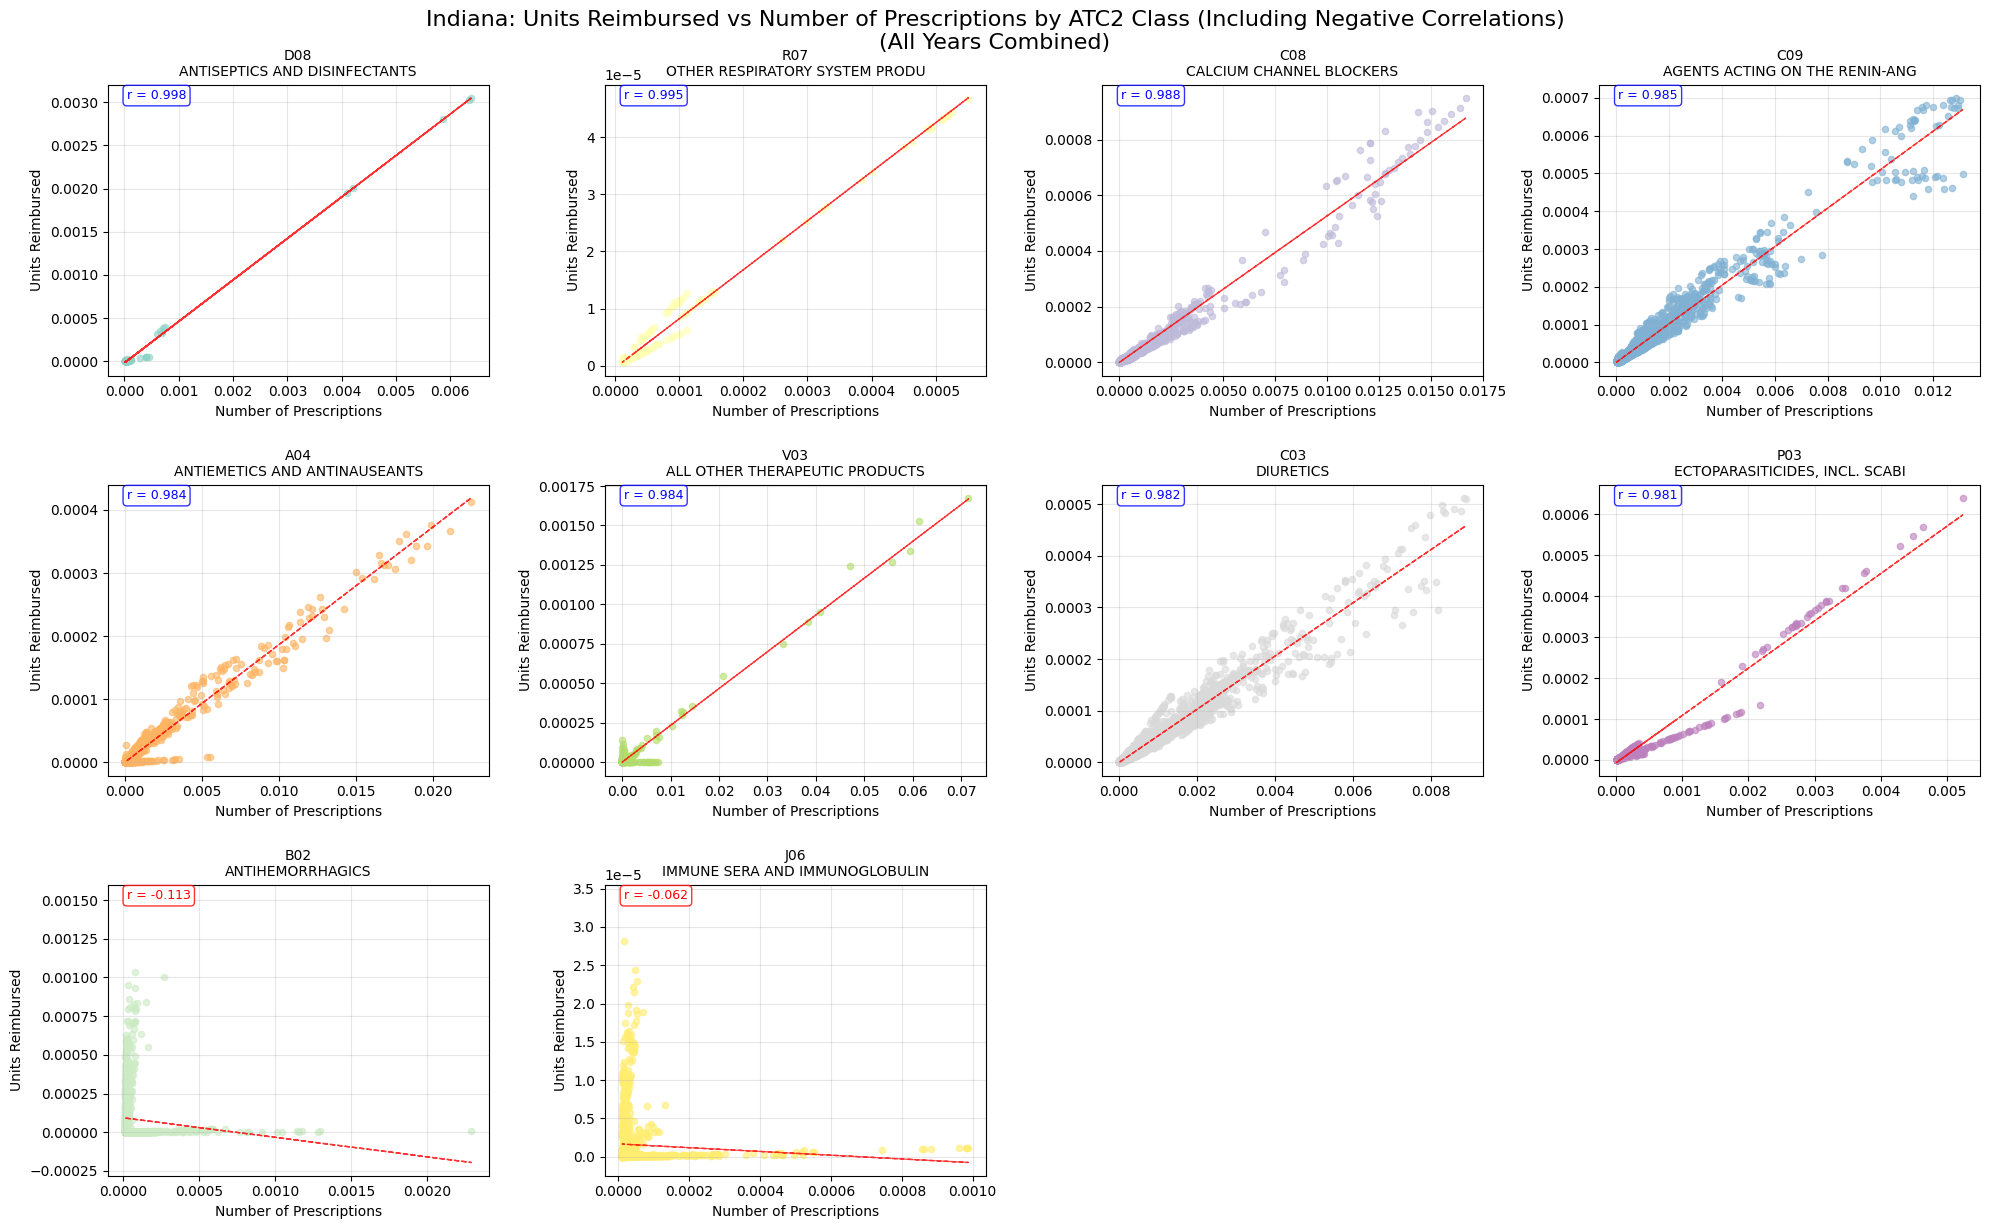


PLOT SUMMARY - INDIANA ATC CLASSES
ATC2  Name                           Records  Correlation  Type    
------------------------------------------------------------------------------------------
D08   ANTISEPTICS AND DISINFECTANT   104      0.9985       Positive
R07   OTHER RESPIRATORY SYSTEM PRO   178      0.9946       Positive
C08   CALCIUM CHANNEL BLOCKERS       5591     0.9885       Positive
C09   AGENTS ACTING ON THE RENIN-A   11667    0.9850       Positive
A04   ANTIEMETICS AND ANTINAUSEANT   3835     0.9844       Positive
V03   ALL OTHER THERAPEUTIC PRODUC   1999     0.9836       Positive
C03   DIURETICS                      10064    0.9823       Positive
P03   ECTOPARASITICIDES, INCL. SCA   449      0.9807       Positive
B02   ANTIHEMORRHAGICS               1101     -0.1128      Negative
J06   IMMUNE SERA AND IMMUNOGLOBUL   1290     -0.0619      Negative


In [11]:

#covarience_results = NDCATC_ind.covariance_look(years_list)

# Example 1: Indiana only
## correlation_results_IN = NDCATC_ind.correlation_look(years_list, state_filter='IN', include_national=False)

# Example 2: Both Indiana and National
## correlation_results_both = NDCATC_ind.correlation_look(years_list, state_filter='IN', include_national=True)

# Example 3: National only
## correlation_results_national = NDCATC_ind.correlation_look(years_list, state_filter=None, include_national=True)

#Plotting correlation
plot_results = NDCATC_ind.plot_units_vs_prescriptions_by_atc(years_list, include_negative=True)

RUNS TEST ANALYSIS: Testing for Randomness in Units Reimbursed and Number of Prescriptions
Loading 2017 data... ✓ (1,931,088 records)
Loading 2018 data... ✓ (2,022,672 records)
Loading 2019 data... ✓ (2,109,684 records)
Loading 2020 data... ✓ (2,173,775 records)
Loading 2021 data... ✓ (2,287,508 records)
Loading 2022 data... ✓ (2,353,181 records)
Loading 2023 data... ✓ (2,385,896 records)
Loading 2024 data... ✓ (2,338,667 records)

PANEL 1: STATE x ATC2 CLASSES RUNS TEST

State x ATC2 Results: 29248 combinations analyzed
Units Reimbursed - Significant non-randomness: 16250/29248 (55.6%)
Number of Prescriptions - Significant non-randomness: 11540/29248 (39.5%)

Top 10 Most Significant Units Reimbursed Results (State x ATC2):
State ATC2_Class                       ATC2_Name  Units_Runs_Stat Units_P_Value  N_Records
   CA        J01 ANTIBACTERIALS FOR SYSTEMIC USE       -37.762811      0.000000       5653
   MA        N06                PSYCHOANALEPTICS       -37.993428      0.000000     

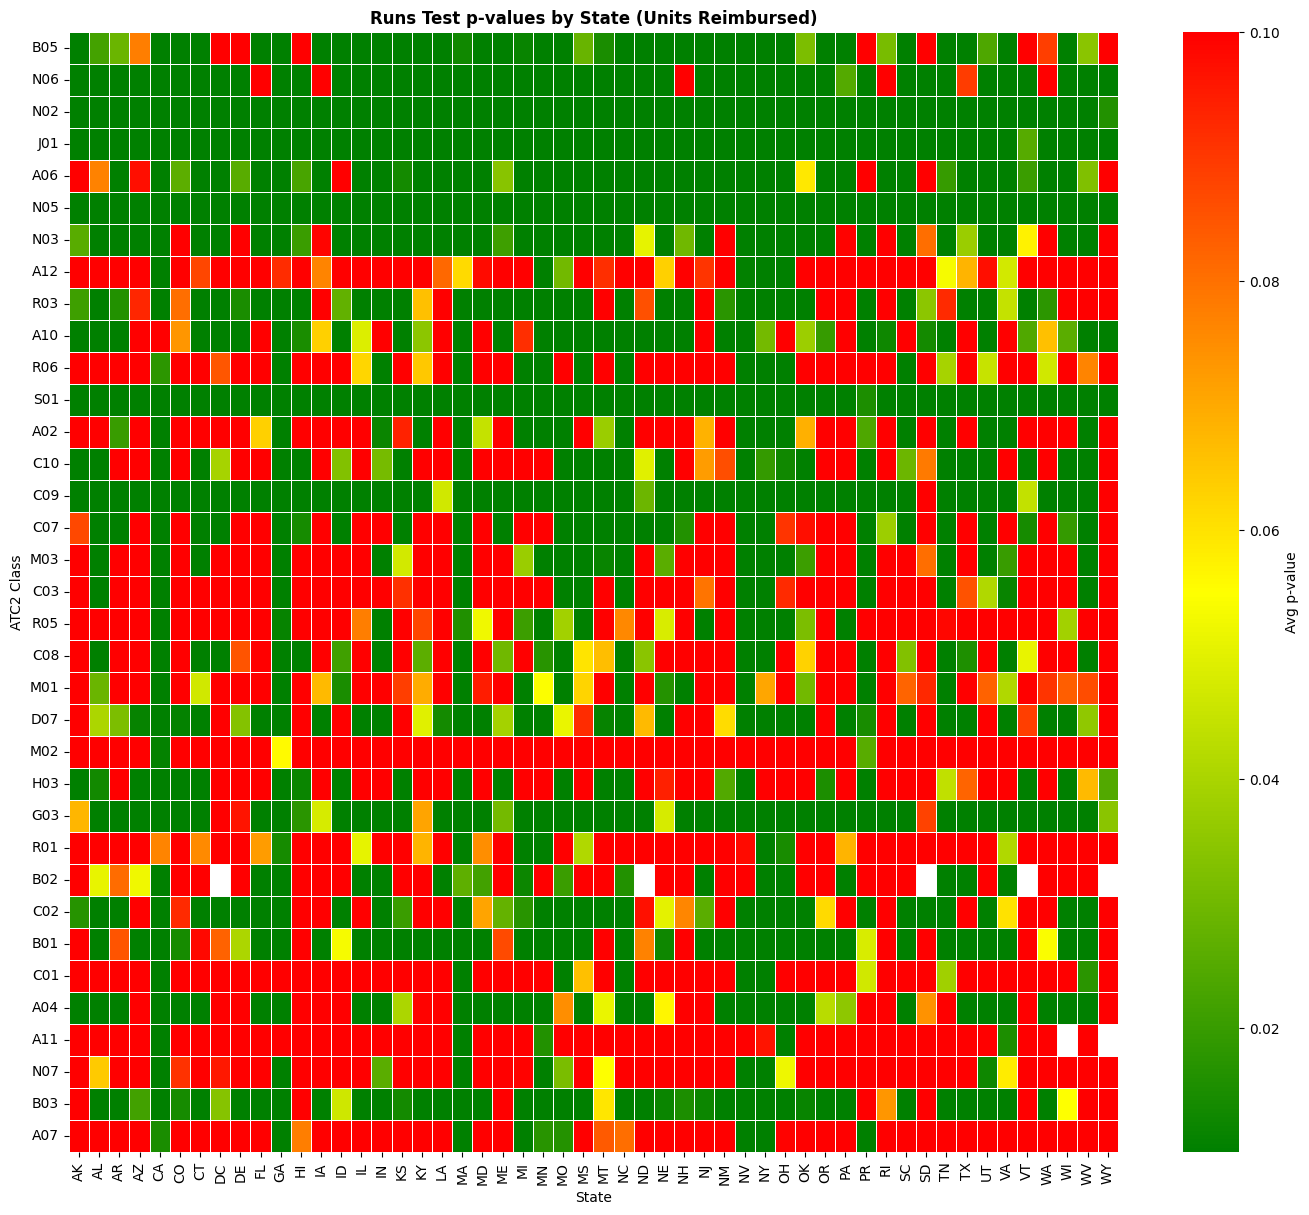

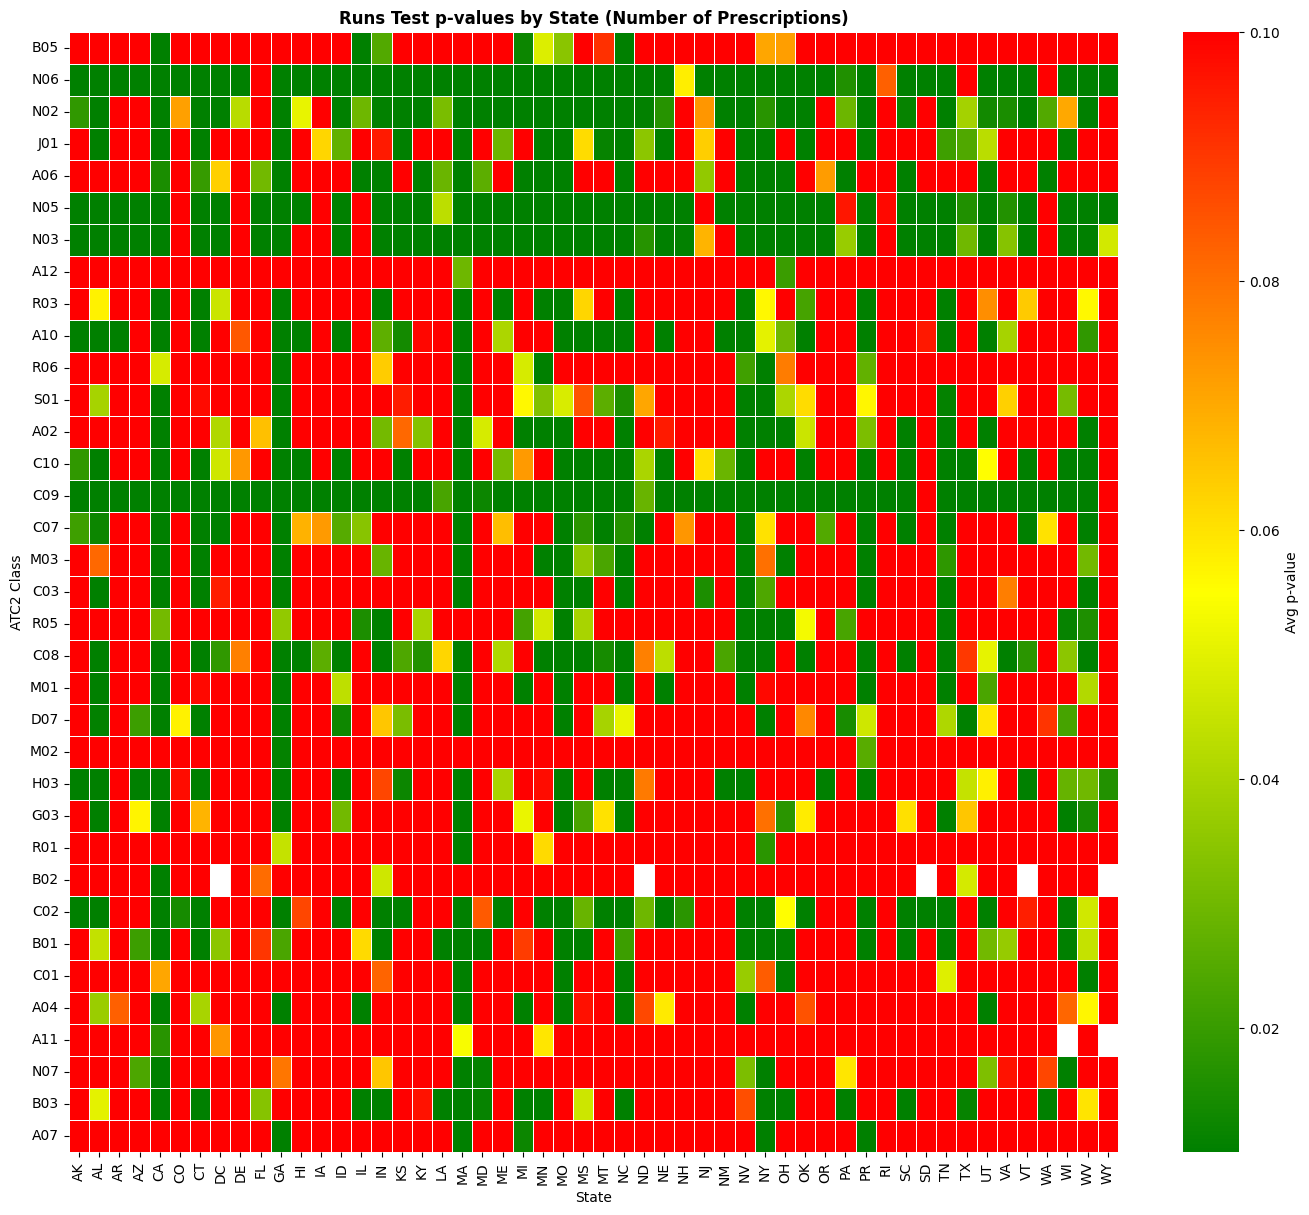

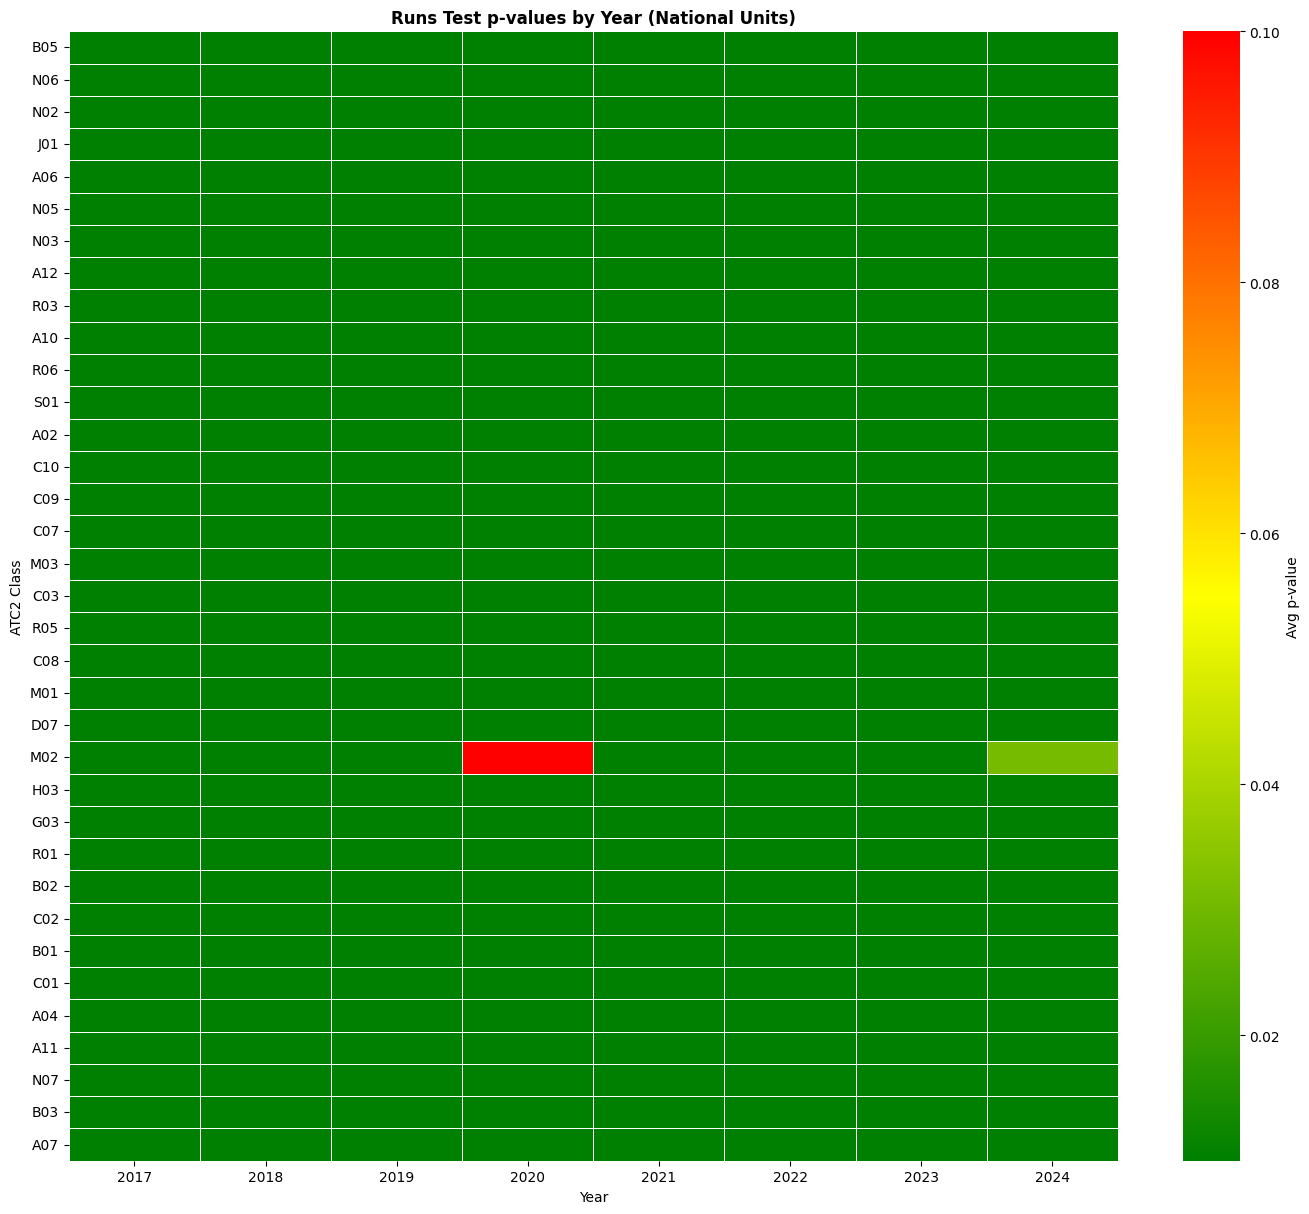

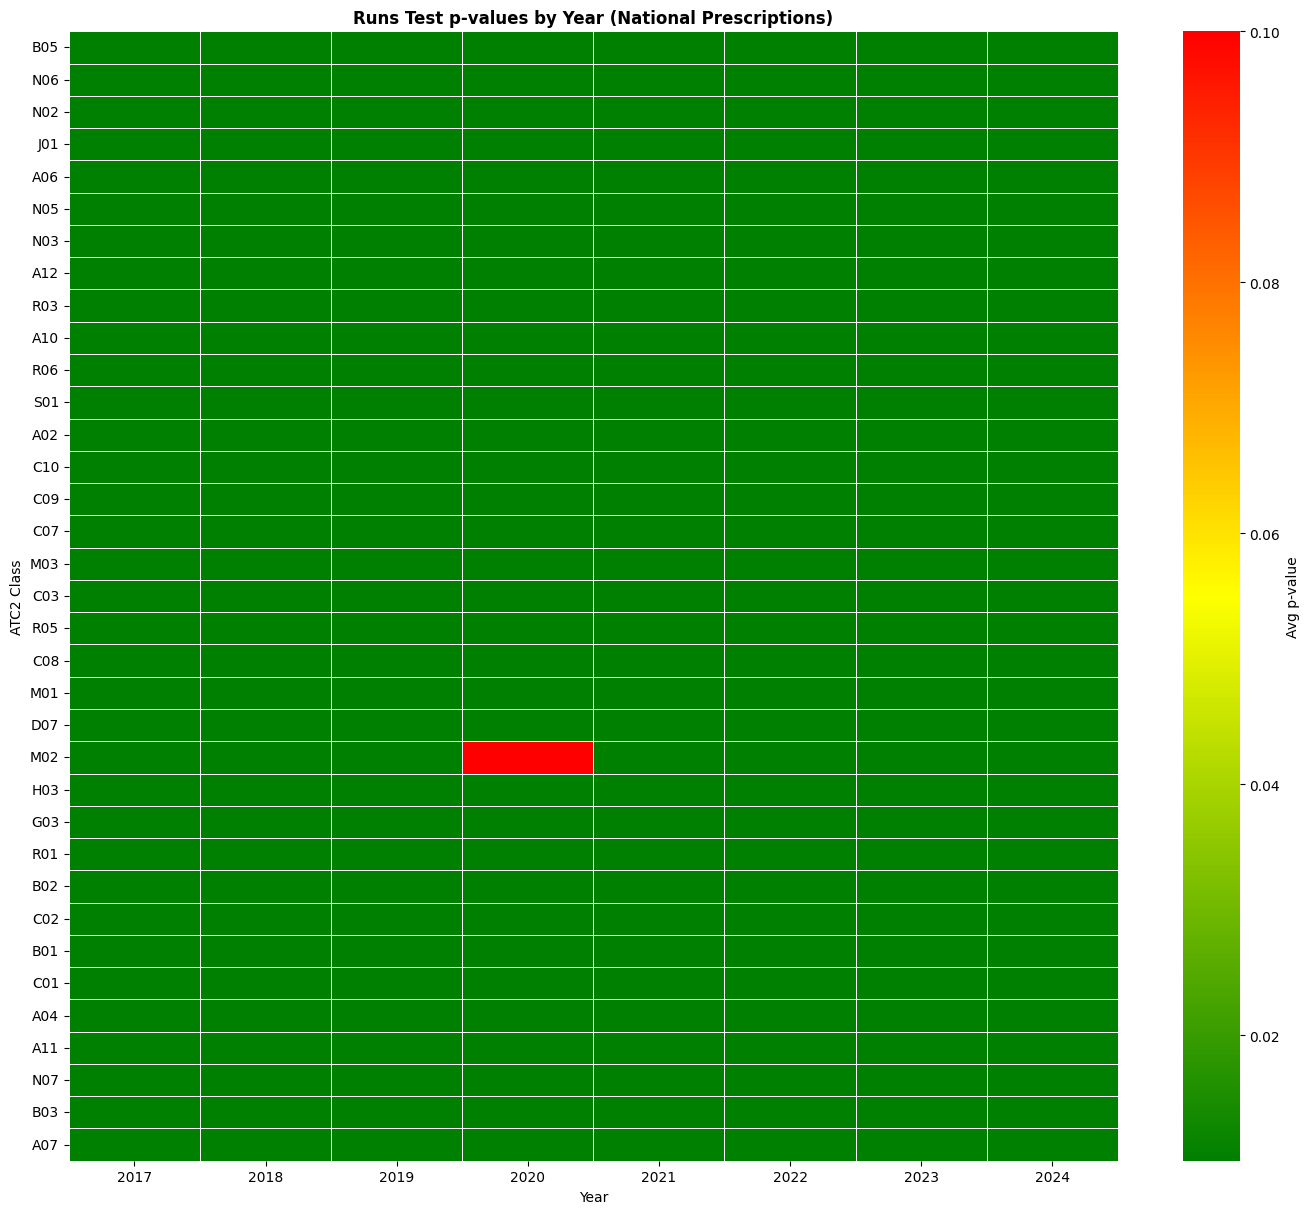

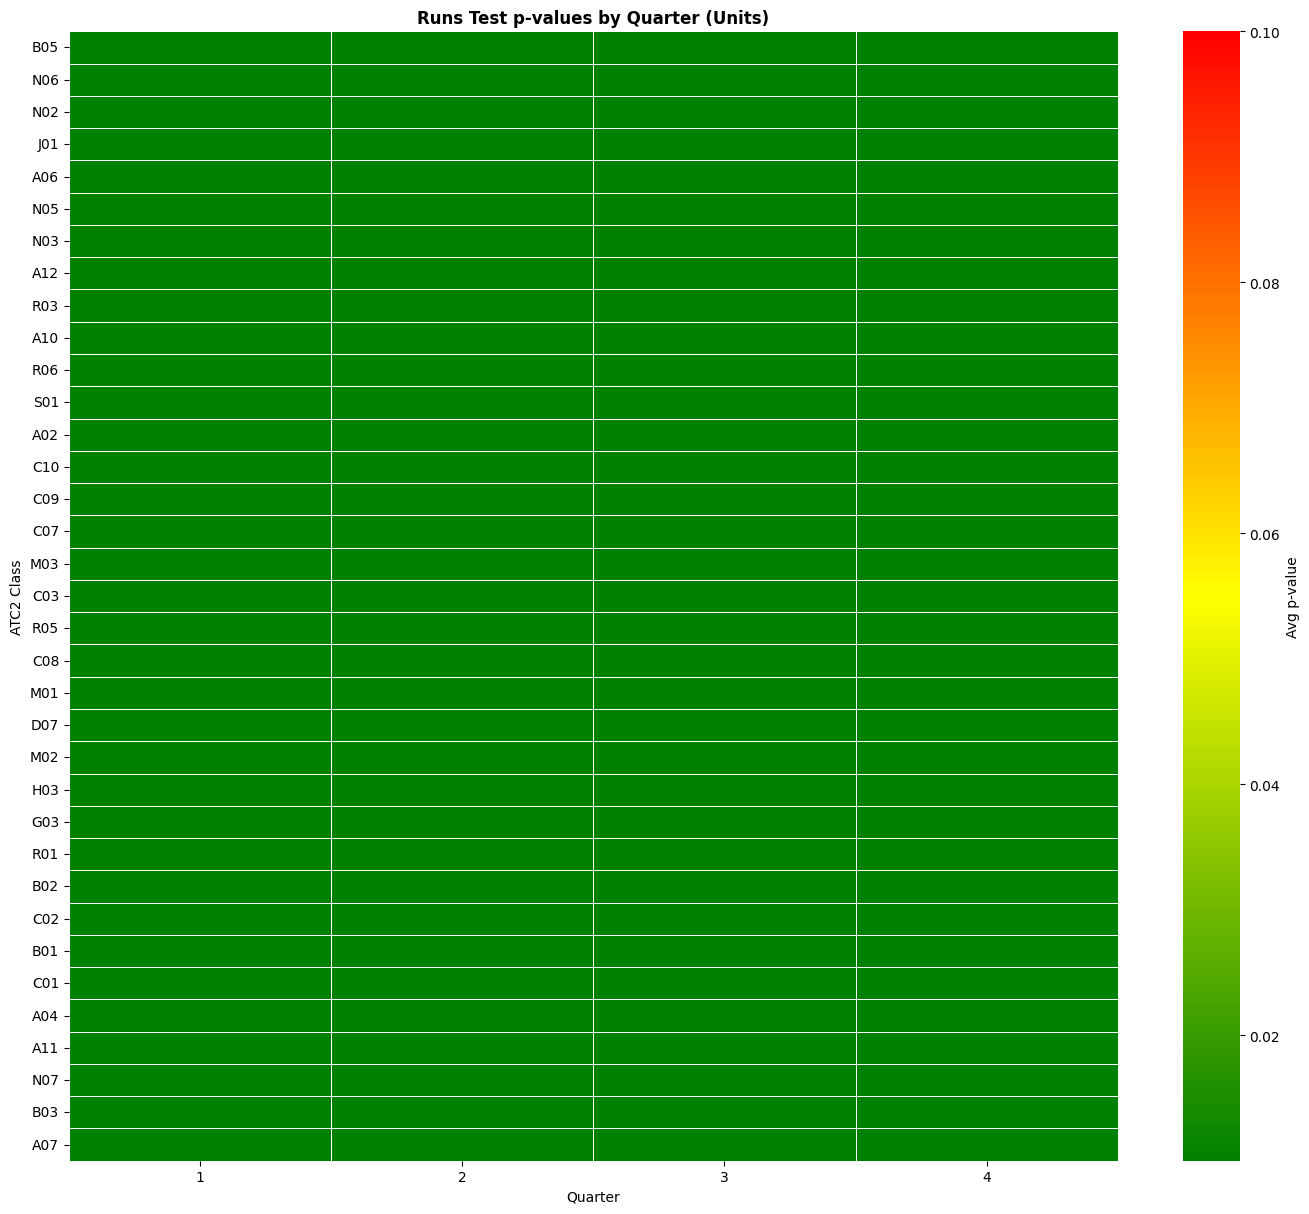

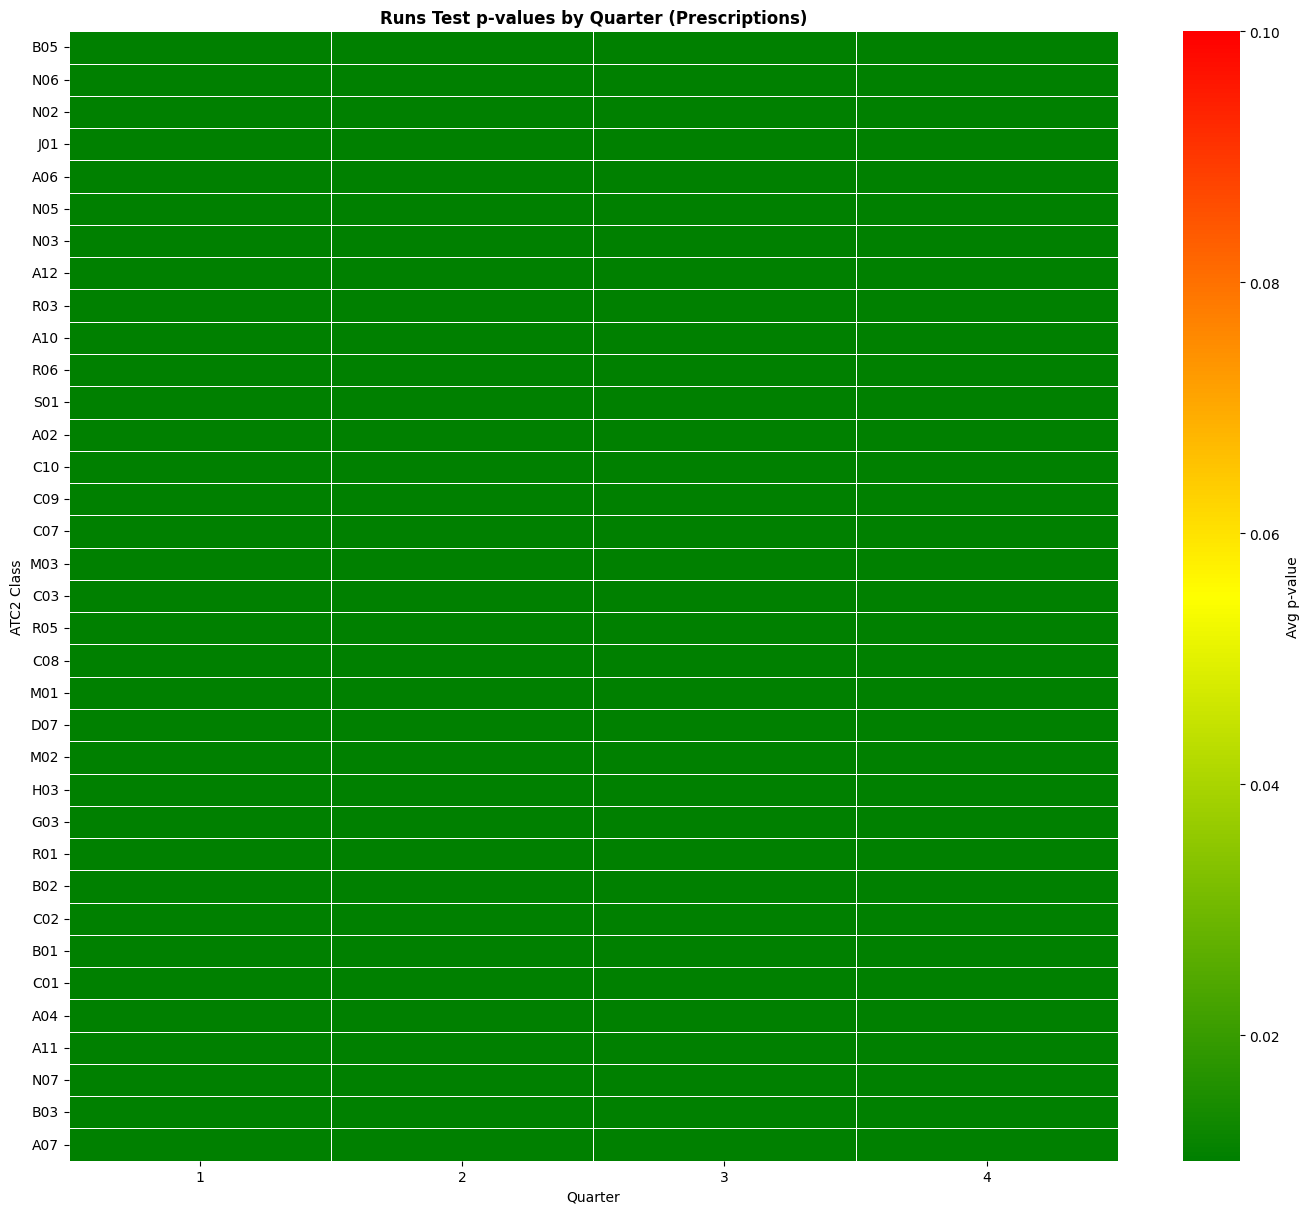

In [10]:

# Run the three-panel correlation analysis
# correlation_results = NDCATC_ind.correlation_look(years_list, min_records=25)

# Uncomment the line below to run the analysis
# runs_results = NDCATC_ind.runs_test_analysis(years_list, min_records=25, generate_heatmaps=True, export_results=True)
runs_results = NDCATC_ind.runs_test_analysis(years_list, min_records=25, generate_heatmaps=True)